# Training a GAN

This week we'll try to train a generative adversarial network! We'll use our favorite set of 28x28 pixels: the MNIST dataset.

This is a simple MNIST image sampler (remember a lot of this code in the exercises is not optimal, for production us you could e.g. us PyTorch dataloaders. You can just copy this code. Note that it normalizes the images to live in the domain `[-1,1]`

```python
import mnist
import torch
import matplotlib.pyplot as plt
import numpy as np

TRAIN = mnist.train_images()
def sample_mnist(N):
    idx = np.random.choice(np.arange(len(TRAIN)), N)
    X = 2*(TRAIN[idx]/256-0.5)
    return torch.FloatTensor(X)
```

# Step 1: Make Generator and Discriminator Networks

The core idea of a GAN is that you have two neural networks in competition to each
other. So as a first step, we need functions to create these networks.

The generator should take a vector of size `noise_dim` and map it into a `(28,28)` image. 

* Create a `make_generator` function that returns images. You can Basically use an MLP and that ends in a `28 * 28 = 784` dimensional vector and finish it off with a `nn.Tanh` layer (to make the output live in `[-1,1]` and a `nn.Unflatten(-1,(28,28))` to reshape the output to a square image.

* Create a `make_discriminator` function that takes in `(28,28)` images and then maps it into a binary classification decision (i.e. a sigmoid output). You can use `nn.Flatten` to map `(28,28)` into a `784`-vector and then continue with a standard MLP

* Use `torch.randn(shape)` to verify that your networks behave correctly and plot e.g. an example output of an untrained generator using `plt.imshow()`

My suggestion is to use 3-4 hidden layers with width of 100 for both networks


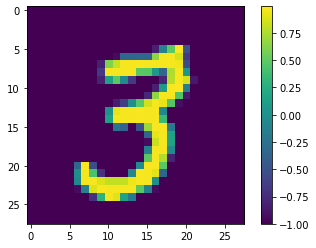

In [1]:
import mnist
import torch
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as skld

TRAIN = mnist.train_images()
def sample_mnist(N):
    idx = np.random.choice(np.arange(len(TRAIN)), N)
    X = 2*(TRAIN[idx]/256-0.5)
    return torch.FloatTensor(X)

plt.imshow(sample_mnist(10)[0])
plt.colorbar()

torch.Size([123, 1])


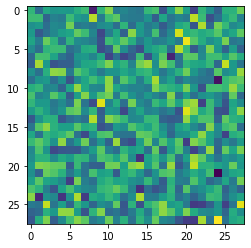

In [2]:
data_dim = 28*28
noise_dim = 128

make_gener = lambda: torch.nn.Sequential(
    torch.nn.Linear(noise_dim,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,data_dim),
    torch.nn.Tanh(),
    torch.nn.Unflatten(-1,(28,28))
)
make_discr = lambda: torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(data_dim,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,1),
    torch.nn.Sigmoid()
)

print(make_discr()(torch.randn(123,28,28)).shape)
plt.imshow(make_gener()(torch.randn(123,128))[0].detach())

## Step 2 - creating a discriminator training function

Using the function `sample_mnist` and a generator model create a function `make_real_and_fake(N, generator_model)` that creates a mixture batch in which real images are labeled `1` and fake ones `0`

```python
def make_real_and_fake(N, generator_model):
    real = sample_mnist(N)
    fake = generator_model(torch.randn(N,noise_dim))
    X = torch.cat([real,fake])
    y = torch.cat([torch.ones(N,1), torch.zeros(N,1)])
    return X,y
```

With this we can create training steps for the discriminator and the generators

Write a function `train_discriminator(Nbatch, opt, generator, discriminator)` implementing the following steps

* Zero out any previous gradients in the optimizer
* create a mixed batch of real and fake images of size (Nbatch)
* compute the standard binary cross entropy loss
* calculate gradients and perform a gradient descent update step
* return the loss value


## Step 3 - creating a generator training function

Write a function `train_generator(Nbatch, opt, generator, discriminator)` implementing it in a very similar way:

* Zero out any previous gradients in the optimizer
* create a mixed batch of real and fake images of size (Nbatch)
* **compute the generator loss (see below)**
* calculate gradients and perform a gradient descent update step
* return the loss value


As discussed in the lecture the standard generator loss would be 

$$\log (1 - D(\mathrm{fake images}))$$

where $D(\dots)$ is the discriminator network. But this leads to less optimal training dynamics, such that the following loss is a bit more favorable

$$ - \log D(\mathrm{fake images})$$

That is, when computing the loss

* first filter out only the fake images from a mixed batch
* pass them through the discriminator 
* use the mean negative log discriminator score as a loss function


In [3]:
def make_real_and_fake(N, generator_model):
    real = sample_mnist(N)
    fake = generator_model(torch.randn(N,noise_dim))
    X = torch.cat([real,fake])
    y = torch.cat([torch.ones(N,1), torch.zeros(N,1)])
    return X,y

def train_discriminator(Nbatch, opt, generator, discriminator):
    opt.zero_grad()

    X,y  = make_real_and_fake(Nbatch, generator)
    pred = discriminator(X)
    loss = torch.nn.functional.binary_cross_entropy(pred,y)

    loss.backward()
    opt.step()
    
    return loss

def train_generator(Nbatch, opt, generator, discriminator):
    opt.zero_grad()

    X,y  = make_real_and_fake(Nbatch, generator)
    pred_fake = discriminator(X[y[:,0]==0])
    loss = -torch.log(pred_fake).mean()
    
    loss.backward()
    opt.step()
    
    return loss

## Step 3 - Training the GAN

We now proceed to train the GAN. The training will use both of the functions we had before and alternatve them in training. 

* Create both discriminators and generators
* Create TWO optimizers, one that optimizes the discriminator parameters and one that optimizes the generator parameters

* For each iteration of the training loop
    * train first the generator 
    * then train the discriminator
    * track the generator and discriminator losses
    
* optionally write a plotting function that prints out what type of images the current generator produces as you are training


Train the GAN for ~ 200k steps (with batch size `100` and learning rate `1e-4`. If everything is implemented correctly this should produce fairly good-looking MNIST images. It might take ~50k steps or so before things look recognizable, so be patient.

0


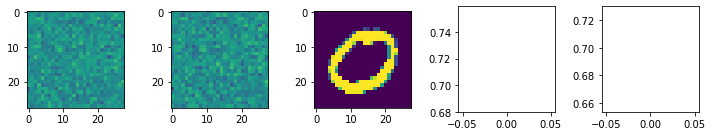

10000


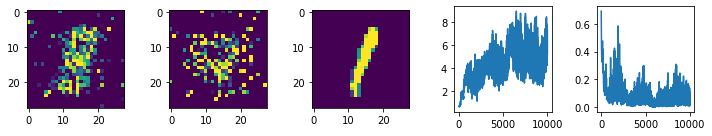

20000


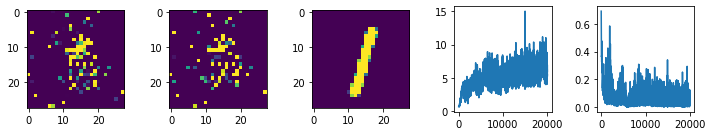

30000


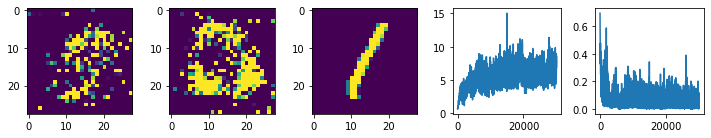

40000


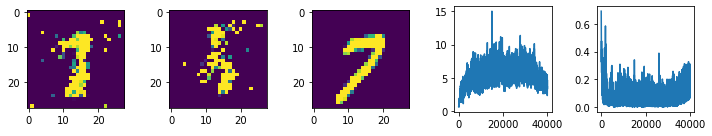

50000


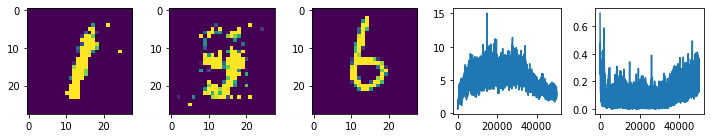

60000


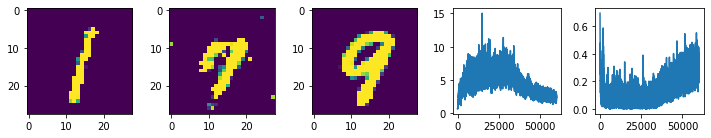

70000


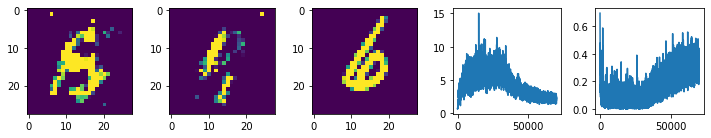

80000


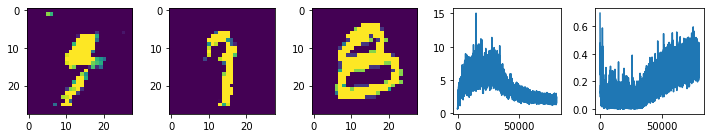

90000


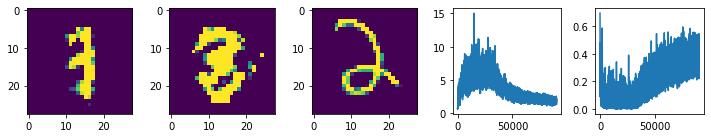

100000


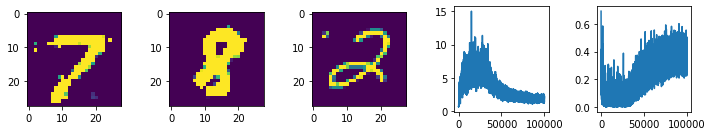

110000


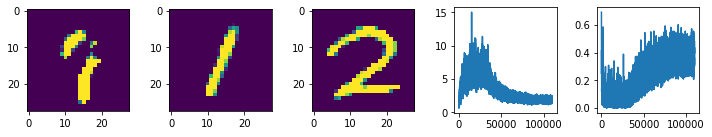

120000


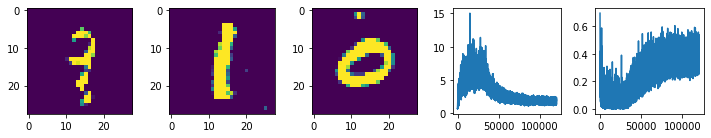

130000


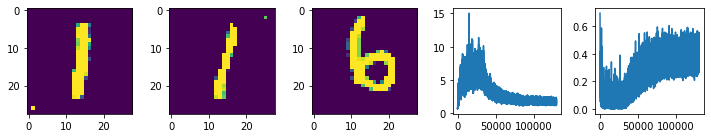

140000


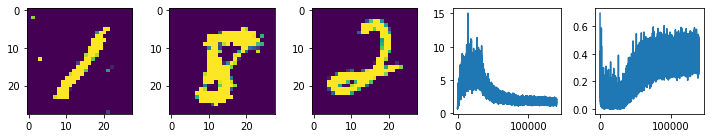

150000


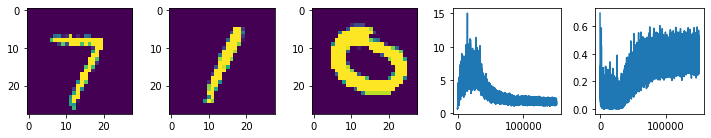

160000


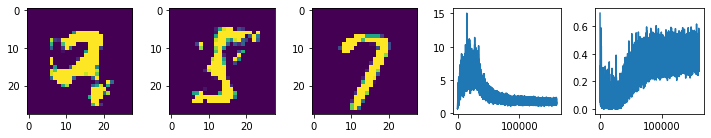

170000


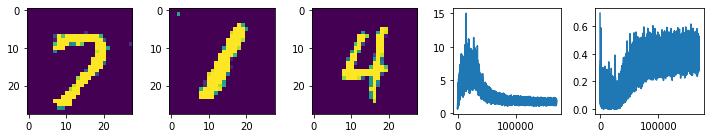

180000


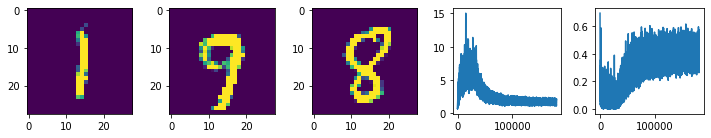

190000


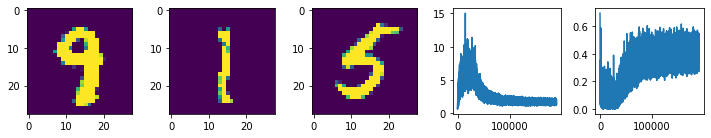

In [4]:
def plot_gan(model,losses):
    losses = np.array(losses)
    model.eval()
    f,axarr = plt.subplots(1,5)
    with torch.no_grad():
        generations = model(torch.randn(2,noise_dim)).detach()
    reals = sample_mnist(2)
    axarr[0].imshow(generations[0], vmin = -0.5, vmax = 0.5)
    axarr[1].imshow(generations[1], vmin = -0.5, vmax = 0.5)
    axarr[2].imshow(reals[0], vmin = -0.5, vmax = 0.5)
    axarr[3].plot(losses[:,0])
    axarr[4].plot(losses[:,1])
    plt.gcf().set_size_inches(10,2)
    f.set_tight_layout(True)
    
            
def train():
    discriminator = make_discr()
    generator = make_gener()
    opt_d = torch.optim.Adam(discriminator.parameters(), 1e-4)
    opt_g = torch.optim.Adam(generator.parameters(), 1e-4)
    losses = []
    Nbatch = 100

    for i in range(100*200*10):
        loss_g = train_generator(Nbatch, opt_g, generator, discriminator)
        loss_d = train_discriminator(Nbatch, opt_d, generator, discriminator)
        losses.append([float(loss_g), float(loss_d)])
        if i % 10000 == 0:
            print(i)
            plot_gan(generator,losses)
            plt.show()
    return generator

model = train()

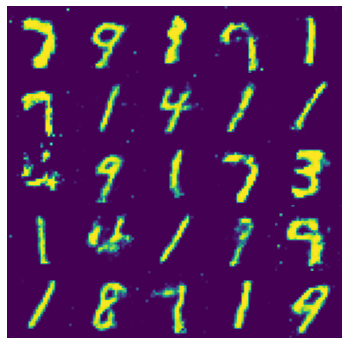

In [5]:
f,axarr = plt.subplots(5,5)
with torch.no_grad():
    generations = model(torch.randn(len(axarr.ravel()),noise_dim)).detach()
for ax,gen in zip(axarr.ravel(),generations):
    ax.imshow(gen)
    ax.axis('off')
f.set_facecolor('w')
plt.subplots_adjust(hspace=0, wspace=0)
f.set_size_inches(6,6.1)